<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/comet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml
from comet_ml import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.5 MB/s eta 0:00:00


what I am trying to do is that I want to prove that the given method can produce a better standard cnn. which means that the validation score would reduce as the increasing epoch.

In [2]:
from functools import partial
EPOCH_PARAM_NAMES = {'batch_size', 'learning_rate', 'smoothing_fact'}

def _experiment_to_row(e, param_names=None, model=None):

    metric_summaries = {sm['name']: sm for sm in e.get_metrics_summary()}
    def mget_summary(name, key, default=None):
        sm = metric_summaries.get(name)
        if sm is None:
            return default
        return sm.get(key, default)

    # ---------- 1) Best step / epoch from 'val' ----------
    best_step = mget_summary('val', 'stepMax', default=None)
    best_epoch = float('nan')

    if best_step is not None:
        try:
            best_step = int(best_step)
            best_epoch = best_step + 1  # 1-based
        except (TypeError, ValueError):
            best_step = None

    best_val = mget_summary('val', 'valueMax', default=float('nan'))
    try:
        best_val = float(best_val)
    except (TypeError, ValueError):
        best_val = float('nan')

    stop_epoch_raw = mget_summary('val', 'stepCurrent', default=None)
    if stop_epoch_raw is not None:
        try:
            stop_epoch_val = int(stop_epoch_raw) + 1
        except (TypeError, ValueError):
            stop_epoch_val = float('nan')
    else:
        stop_epoch_val = float('nan')

    row = {
        "exp_key": getattr(e, "key", None),
        "stop_epoch": stop_epoch_val,
        "best_epoch": best_epoch,
    }

    # ---------- 2) Hyperparameters ----------
    allowed = set(param_names) if param_names is not None else EPOCH_PARAM_NAMES
    params = {}
    for p in e.get_parameters_summary():
        name = p.get("name")
        if name in allowed:
            params[name] = p.get("valueCurrent", None)

    params.update(row)

    # If we don't know the best_step, we can't align metrics → return NaNs
    if best_step is None:
        # We still want val/dbvae columns so downstream code doesn't explode
        params['val'] = best_val
        params['dbval'] = float('nan')
        if model == 'dbvae-final':
            params['val_WM'] = params['val_WF'] = float('nan')
            params['val_BM'] = params['val_BF'] = float('nan')
        return params

    # ---------- 3) Collect metrics at best_step ----------
    metrics_at_best = {}

    # What names we care about
    if model == 'dbvae-final' or model == 'standard-final-exp':
        needed = {'val_WM', 'val_WF', 'val_BM', 'val_BF', 'val'}
    else:
        # for non-final models we want val + some fairness metric (dbval/bias/dbvae)
        needed = {'val', 'dbval', 'bias', 'dbval'}

    for m in e.get_metrics():
        name = m.get('metricName')
        if name not in needed:
            continue

        step_raw = m.get('step')
        if step_raw is None:
            continue
        try:
            step = int(step_raw)
        except (TypeError, ValueError):
            continue

        if step != best_step:
            continue

        val_raw = m.get('metricValue')
        try:
            metrics_at_best[name] = float(val_raw)
        except (TypeError, ValueError):
            metrics_at_best[name] = float('nan')

    # ---------- 4) Fill record depending on model ----------
    if model == 'dbvae-final' or model== 'standard-final-exp':
        # group metrics at best
        val_WM = metrics_at_best.get('val_WM', float('nan'))
        val_WF = metrics_at_best.get('val_WF', float('nan'))
        val_BM = metrics_at_best.get('val_BM', float('nan'))
        val_BF = metrics_at_best.get('val_BF', float('nan'))
        val_overall = metrics_at_best.get('val', best_val)

        params['val_WM'] = val_WM
        params['val_WF'] = val_WF
        params['val_BM'] = val_BM
        params['val_BF'] = val_BF
        params['val']   = val_overall

        # dbval = max(group_means) - min(group_means) at best_step
        groups = [v for v in [val_WM, val_WF, val_BM, val_BF] if not np.isnan(v)]
        if groups:
            dbval = max(groups) - min(groups)
        else:
            dbval = float('nan')
        params['dbval'] = dbval

    else:
        # Non dbvae-final models: val at best_step + fairness metric at best_step
        val_overall = metrics_at_best.get('val', best_val)
        params['val'] = val_overall

        # Try dbval, then bias, then dbval (whatever you logged)
        db_candidate = metrics_at_best.get('dbval')
        if db_candidate is None or np.isnan(db_candidate):
            db_candidate = metrics_at_best.get('bias')
        if db_candidate is None or np.isnan(db_candidate):
            db_candidate = metrics_at_best.get('dbval', float('nan'))

        try:
            db_candidate = float(db_candidate)
        except (TypeError, ValueError):
            db_candidate = float('nan')

        params['dbval'] = db_candidate

    return params


def get_param_metric_records(experiments, param_names=None, model=None):
    print('experiment record retrieving...')
    mapper = partial(_experiment_to_row, param_names=param_names, model=model)
    rows = list(map(mapper, experiments))
    df = pd.DataFrame(rows)
    df.index = df.index + 1
    return df


In [3]:
# --- 1) pick representative trial per hyperparameter set ---
def pick_representatives(record: pd.DataFrame, by_params, measure):
    grouped = record.groupby(by_params, dropna=False)
    reps = []

    for params, group in grouped:
        vals = group['val']
        if vals.dropna().empty:
            continue

        if measure == "max":
            idx = vals.idxmax()

        elif measure == "median":
            med = vals.median()
            idx = (vals - med).abs().idxmin()

        else:
            raise ValueError(f"Unknown measure '{measure}'. Use 'max' or 'median'.")

        if pd.notna(idx):
            reps.append(idx)
    return reps


def metrics_at_epoch(exp, epoch, names=('loss_ema','val','dbval')):
    # build per-metric -> {step: value}
    store = {n: {} for n in names}
    for m in exp.get_metrics():
        name = m['metricName']
        if name in store:
            step = int(m['step'])
            store[name][step] = float(m['metricValue'])

    out = {}
    for n in names:
        if epoch in store[n]:
            out[n] = store[n][epoch]
        elif (epoch - 1) in store[n]:
            out[n] = store[n][epoch - 1]
        else:
            out[n] = float('nan')
    return out

def build_summary(model,measure, by_params):
    print('generating summary....')
    record = model.record
    exps = model.experiments
    # Step 1: pick the representative trial (median best_val) for each hyperparameter group
    best_idx = pick_representatives(record, by_params, measure)
    # Step 2: define a helper function that will run on each record
    def get_metrics_for_row(row):
        # exp indices are 0-based, record indices are 1-based (from get_param_metric_records)
        exp = exps[row.name - 1]
        best_epoch = int(row['best_epoch'])
        best_val = float(row['val'])

        # Extract metrics at that epoch
        metrics = metrics_at_epoch(exp, best_epoch-1, names=('loss_ema','val','dbval'))
        return pd.Series({
            'exp_key': row['exp_key'],
            'loss': metrics['loss_ema'],
            'val': metrics['val'],
            'dbval': metrics['dbval'],
            'best_epoch': best_epoch,
        })

    # Step 3: apply `map` (or technically pandas `apply`) to selected records
    selected_records = record.loc[best_idx]
    metrics_summary = selected_records.apply(get_metrics_for_row, axis=1)

    # Step 4: merge param columns + metrics summary
    param_cols = record.columns.intersection(by_params)
    summary_df = pd.concat([selected_records[param_cols].reset_index(drop=True),
                            metrics_summary.reset_index(drop=True)], axis=1)

    return summary_df.sort_values(by=f'val', ascending=False).reset_index(drop=True)

In [4]:
def plot(comet,record,y):
    if comet.model == 'dbvae':
        params = [
            ['batch_size', 'learning_rate'],
            ['smoothing_fac','latent_dim']
        ]
        for i in range(len(params)):
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            for j in range(len(params[i])):
                ax[j].scatter(record[params[i][j]], record[y])
                ax[j].set_xlabel(params[i][j])
                ax[j].set_ylabel(y)
                ax[j].set_title(f"{params[i][j]} vs. {y}")
                ax[j].grid(True)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()

    elif comet.model == 'standard':
        params = ['batch_size', 'learning_rate']
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for i in range(len(params)):
            ax[j].scatter(record[params[i][j]], record[y])
            ax[j].set_xlabel(params[i][j])
            ax[j].set_ylabel(y)
            ax[j].set_title(f"{params[i][j]} vs. {y}")
            ax[j].grid(True)
        for sub_ax in fig.get_axes():
            sub_ax.label_outer()
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [5]:
def get_metric_names(model):
  metricName = []
  for x in model.experiments[0].get_metrics():
    if x['metricName'] not in metricName and x['metricName'][:3]!='sys':
      metricName.append(x['metricName'])
  print(sorted(metricName))

In [6]:
def project_name(c, name):
  name = f'{name}-c'
  for x in range(3):
    if len(str(c[x]))==1: name+=f'-{c[x]}'
    else: name+=f'-{str(c[x])[0]}-{str(c[x])[2:]}'
  return name

In [7]:
class comet():
  def __init__(self, model, measure, c=None, expmt=1):
      COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"
      self.api = API(COMET_API_KEY)
      self.workspace = "zhiyuan-jin"
      self.model = model

      if model == 'standard':
          self.projectName = "standard-p-3"
          self.params = ['batch_size', 'learning_rate']
      elif model == 'standard-final-exp':
          self.projectName = "standard-final-exp"
          self.params = ['batch_size', 'learning_rate']
      else:  # 'debiasing', 'dbvae-final', etc.
          self.projectName = project_name(c, model)
          self.params = ['batch_size', 'learning_rate', 'smoothing_fact']

      try:
          self.experiments = self.api.get(
              project_name=self.projectName,
              workspace=self.workspace
          )
      except Exception as e:
          print(
              f"Error: Could not find project '{self.projectName}' "
              f"in workspace '{self.workspace}'. Please check the project name and workspace in Comet ML."
          )
          raise e

      # >>> pass self.model here <<<
      self.record = get_param_metric_records(self.experiments, self.params, model=self.model)

      self.top_records = None
      self.summary = build_summary(self, measure, self.params)

  def delete_record_comet(self, keys):
    print('are you sure you want to delate following records?: ')
    for x in keys:
      print(x)
    answer = input('')
    if answer == 'yes':
      for key in keys:
        self.api.delete_experiment(key)
        print(f"Deleted experiment {key}")
      self.experiments = self.api.get(project_name=self.projectName, workspace="zhiyuan-jin")
      self.record = get_param_metric_records(self.experiments,self.params)
    else:
      print('not deleted')
  def plot_relation(self, x,y):
    if x == 'learning_rate': X = [float(l) for l in self.summary['learning_rate']]
    elif x == 'batch_size': X = [int(l) for l in self.summary['batch_size']]
    elif y == 'batch_size': Y = [int(l) for l in self.summary['batch_size']]
    else: X = self.summary[x]
    Y = self.summary[y]
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y} across Experiments")
    plt.grid(True)
    plt.show()
  def delete_nan_validation(self, confirm=True):
      nan_columns = self.v.columns[self.v.iloc[-1].isna()]
      nan_exps = self.record.loc[nan_columns.to_list()]
      if nan_exps.empty:
          print("✅ No experiments with NaN validation found.")
          return
      print(f"⚠️ Found {len(nan_exps)} experiments with NaN validation:")
      print(nan_exps[['exp_key', 'exp_name', 'validation']])
      if not confirm:
          answer = 'yes'
      else:
          answer = input("Type 'yes' to confirm deletion: ")
      if answer.lower() == 'yes':
          for key in nan_exps['exp_key']:
              try:
                  self.api.delete_experiment(key)
                  print(f"Deleted experiment {key}")
              except Exception as e:
                  print(f"❌ Failed to delete {key}: {e}")
          # Refresh records
          self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
          self.record = get_param_metric_records(self.experiments, self.params)
          print("✅ Refresh complete. Updated experiment list loaded.")
      else:
          print("⏩ Deletion cancelled.")
  def loss_decompose(self,exp):
    total, classification,vae = [],[],[]
    for x in self.experiments[exp].get_metrics():
      if x['metricName']=='loss': total.append(float(x['metricValue']))
      elif x['metricName']=='classification': classification.append(float(x['metricValue']))
      elif x['metricName']=='vae': vae.append(float(x['metricValue']))
    plt.plot(total, label='Total Loss')
    plt.plot(classification, label='classification')
    plt.plot(vae, label='vae')
    plt.legend()
    plt.show()
  def val_trend(self,key):
    val, dbval = [],[]
    for x in self.api.get_experiment_by_key(key).get_metrics():
      if x['metricName']=='val': val.append(float(x['metricValue']))
      elif x['metricName']=='dbval': dbval.append(float(x['metricValue']))
    plt.plot(val, label='val')
    plt.plot(dbval, label='dbval')
    plt.legend()
    plt.show()
  def delete_incomplete_experiment_groups(self, expected_trials=3, confirm=True):
    """
    Delete all experiment trials for groups that contain fewer than expected_trials.

    A "group" means same (batch_size, learning_rate, smoothing_fact)
    depending on self.params.
    """

    # Step 1: count experiments per hyperparameter set
    group_counts = self.record.groupby(self.params)['exp_key'].count()

    # Step 2: find incomplete groups
    incomplete = group_counts[group_counts < expected_trials]

    if incomplete.empty:
        print(f"✅ All experiment groups have at least {expected_trials} trials.")
        return

    print("⚠️ Found incomplete groups (less than expected trials):")
    print(incomplete)

    # Step 3: collect all exp_keys belonging to incomplete groups
    keys_to_delete = []

    for params, _ in incomplete.items():
        batch = self.params
        # filter record rows matching these params
        mask = (self.record[batch[0]] == params[0])
        for i in range(1, len(batch)):
            mask &= (self.record[batch[i]] == params[i])
        keys_to_delete.extend(self.record[mask]['exp_key'].tolist())

    print("\nExperiments to be deleted:")
    for k in keys_to_delete:
        print(" -", k)

    # Step 4: confirmation
    if confirm:
        ans = input("\nType 'yes' to confirm deletion: ")
        if ans.lower() != "yes":
            print("❌ Deletion cancelled.")
            return

    # Step 5: delete through Comet API
    print("\nDeleting experiments...")
    for key in keys_to_delete:
        try:
            self.api.delete_experiment(key)
            print(f"Deleted {key}")
        except Exception as e:
            print(f"❌ Failed to delete {key}: {e}")

    # Step 6: refresh state
    self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
    self.record = get_param_metric_records(self.experiments, self.params)
    print("✅ Refresh complete.")


In [41]:
dbvae_final.record

,batch_size,learning_rate,smoothing_fact,exp_key,stop_epoch,best_epoch,val_WM,val_WF,val_BM,val_BF,val,dbval
1,50,6.47E-4,0.6,1396e5fa03c84147830d5f35baf8e9d4,6,3,0.758882,0.793028,0.612410,0.792926,0.739312,0.180618
2,50,6.47E-4,0.6,a255ece6407a42c3b17271017cb9503b,7,4,0.756889,0.600267,0.597285,0.619479,0.643480,0.159604
3,50,6.47E-4,0.6,ba433279fe2940c68924da8b079e82c6,5,2,0.619422,0.647365,0.816393,0.787136,0.717579,0.196971
4,50,6.47E-4,0.6,29bcbb0641c340deb81225bfc90c0d4d,7,4,0.804638,0.817878,0.755536,0.738417,0.779117,0.079461
5,50,6.47E-4,0.6,9637c08091b5474f92dc86b14bc578da,9,6,0.901592,0.792887,0.809295,0.818252,0.830507,0.108704
...,...,...,...,...,...,...,...,...,...,...,...,...
146,25,7.15E-4,1.4,ed34f5c331dc4e4087ebb14a405c42d8,9,6,0.909929,0.838994,0.937888,0.812019,0.874707,0.125869
147,25,7.15E-4,1.4,31be3be38e694798a3da8e14b41e8921,6,3,0.785571,0.837496,0.955852,0.649351,0.807067,0.306501
148,25,7.15E-4,1.4,54fb9c3e4b2146c88dca84d31594b3b9,9,6,0.850634,0.789806,0.902998,0.799151,0.835647,0.113192
149,25,7.15E-4,1.4,f13819b718834c1b8fb1313c939e3e81,5,2,0.802482,0.767787,0.813947,0.588776,0.743248,0.225171


In [39]:
# it compares val/dbval at best epoch acorss standard_cc and dbvae with different smoothing rate
def validate_at_best(measure):
  sf = dbvae_final.record.smoothing_fact.value_counts().index
  dick = {}
  standard_measure = standard_final.record[measure].describe()
  dick['standard_cnn'] = standard_measure
  for smf in sf:
    dick[f'dbvae_{smf}'] = dbvae_final.record[measure].loc[(dbvae_final.record.smoothing_fact==f'{smf}')].describe()
  combined_measure = pd.DataFrame(dick)
  return combined_measure

In [9]:
def get_epoch_avg_history(model, metric='dbval', smoothing_col='smoothing_fact', max_epoch=4):
    """
    Return epoch-avg trajectory but only up to `max_epoch` (1-based epochs).
    Internally Comet steps are 0-based, so we keep step < max_step_limit.

    - Standard model: returns {'all': mean_traj}
    - DBVAE model: returns {smoothing_value: mean_traj}
    """
    import pandas as pd

    # Convert 1-based epoch cap to 0-based step cap
    max_step_limit = int(max_epoch)  # keep steps 0..max_epoch-1

    has_smoothing = smoothing_col in model.summary.columns

    # -------------------------
    # Case 1: Standard CNN
    # -------------------------
    if not has_smoothing:
        print(f'standard cnn with {model.summary.shape[0]} reps...')
        trajectories = []

        for _, row in model.summary.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])  # 1-based

            # cap by both best_epoch and max_epoch
            step_limit = min(best_epoch, max_epoch)  # still 1-based
            step_limit = int(step_limit)             # keep step < step_limit

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()
                vals = {}

                for m in metrics:
                    if m['metricName'] != metric:
                        continue
                    step = int(m['step'])  # 0-based
                    if step < step_limit:
                        vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        return {'all': mean_traj}

    # -------------------------
    # Case 2: DBVAE (group by smoothing_fact)
    # -------------------------
    results = {}

    for sm_val, sm_group in model.summary.groupby(smoothing_col):
        print(f"Processing dbvae smoothing={sm_val} with {len(sm_group)} reps...")
        trajectories = []

        for _, row in sm_group.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])  # 1-based

            step_limit = min(best_epoch, max_epoch)
            step_limit = int(step_limit)

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()
                vals = {}

                for m in metrics:
                    if m['metricName'] != metric:
                        continue
                    step = int(m['step'])
                    if step < step_limit:
                        vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        results[sm_val] = mean_traj

    return results


In [10]:
def box_plot(dbvae_summary, standard_summary, metrix):
  plt.figure(figsize=(10,6))
  smoothing_values = sorted(dbvae_summary["smoothing_fact"].unique())
  # 1. Draw DBVAE boxplots (automatic positions: 1,2,3,...)
  ax = dbvae_summary.boxplot(column=metrix, by="smoothing_fact")
  # 2. Draw STANDARD boxplot manually at x = 0.5
  standard_data = standard_summary[metrix].dropna()
  ax.boxplot(
      [standard_data],
      positions=[0.2],      # position on x-axis
      widths=0.3,
      patch_artist=True,
      boxprops=dict(facecolor="lightgray", alpha=0.5),
      medianprops=dict(color="black")
  )

  # 3. Adjust x-axis labels
  xticks = [0.2] + list(range(1, len(smoothing_values)+1))
  xlabels = ["Standard"] + [str(s) for s in smoothing_values]
  plt.xticks(ticks=xticks, labels=xlabels)
  plt.title(f"Distribution of {metrix}_at_best_epoch across Models")
  plt.suptitle("")
  plt.xlabel("Model Type")
  plt.ylabel(metrix)
  plt.show()

In [11]:
value = 'median'
standard = comet('standard', value)

experiment record retrieving...
generating summary....


In [12]:
c = (1,1,0.0002)
dbvae = comet('dbvae',value, c)

experiment record retrieving...
generating summary....


In [13]:
dbvae_final = comet('dbvae-final', value, c)

experiment record retrieving...
generating summary....


In [14]:
standard_final = comet('standard-final-exp', value, c)

experiment record retrieving...
generating summary....


<Figure size 1000x600 with 0 Axes>

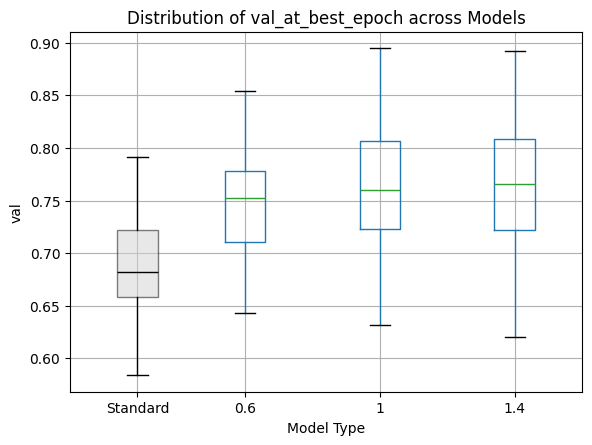

In [97]:
# Boxplot of val by model type
box_plot(dbvae_final.record, standard_final.record, 'val')

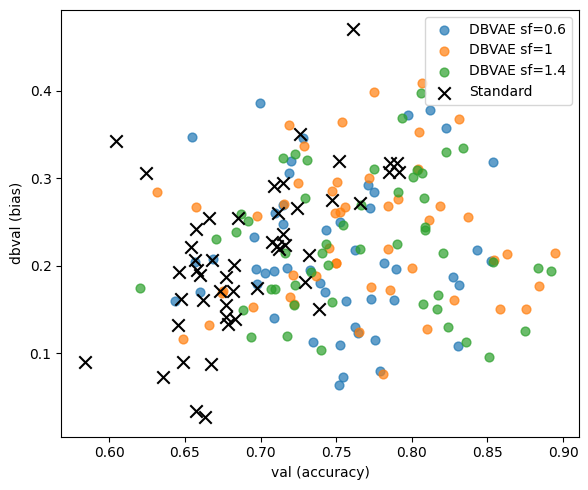

In [20]:
# Scatter of val_best vs dbval_at_best colored by model type.

plt.figure(figsize=(6, 5))

colors = {
    '0.6': 'tab:blue',
    '1':   'tab:orange',
    '1.4': 'tab:green',
}

for sf in ['0.6', '1', '1.4']:
    mask = dbvae_final.record.smoothing_fact == sf
    plt.scatter(
        dbvae_final.record.loc[mask, 'val'],
        dbvae_final.record.loc[mask, 'dbval'],
        color=colors[sf],
        alpha=0.7,
        s=40,
        label=f'DBVAE sf={sf}'
    )

plt.scatter(
    standard_final.record['val'],
    standard_final.record['dbval'],
    color='black',
    marker='x',
    s=80,
    label='Standard'
)

plt.xlabel('val (accuracy)')
plt.ylabel('dbval (bias)')
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
validate_at_best('val_WM')

,standard_cnn,dbvae_0.6,dbvae_1,dbvae_1.4
count,50.000000,50.000000,50.000000,50.000000
mean,0.645578,0.754445,0.746689,0.784782
std,0.061127,0.108714,0.118371,0.111577
min,0.599959,0.599318,0.597065,0.599412
25%,0.600641,0.652048,0.620521,0.706521
50%,0.616388,0.764015,0.767649,0.795346
75%,0.674728,0.804076,0.799337,0.852583
max,0.811121,0.995673,0.999447,0.990157


In [92]:
#Group-wise validation performance
group_cols = ["val_WM", "val_WF", "val_BM", "val_BF"]
cols = {}
for gc in group_cols:
  median = validate_at_best(gc).loc['50%'].to_list()
  median  = list(map(lambda x: round(x, 3), median))
  iqr = validate_at_best(gc).loc['75%'] - validate_at_best(gc).loc['25%']
  iqr = list(map(lambda x: round(x, 3), iqr.to_list()))
  new_cols = map(lambda x: str(median[x])+"\u00B1"+str(iqr[x]), [i for i in range(4)])
  cols[f'{gc[-2:]} (median±IQR)'] =list(new_cols)
Group_wise_validation = pd.DataFrame(cols)
Group_wise_validation.index = ['standard_cnn',	'dbvae_0.6'	,'dbvae_1','dbvae_1.4']
Group_wise_validation

,WM (median±IQR),WF (median±IQR),BM (median±IQR),BF (median±IQR)
standard_cnn,0.616±0.074,0.635±0.108,0.774±0.096,0.682±0.165
dbvae_0.6,0.764±0.152,0.695±0.152,0.796±0.085,0.777±0.166
dbvae_1,0.768±0.179,0.697±0.173,0.793±0.153,0.798±0.089
dbvae_1.4,0.795±0.146,0.703±0.165,0.81±0.125,0.788±0.17


In [105]:
# Bias Metric (dbval)
bias_median = validate_at_best('val').loc['50%']
bias_median = list(map(lambda x: round(x, 3), bias_median))
bias_iqr = validate_at_best('val').loc['75%'] - validate_at_best('val').loc['25%']
bias_iqr = list(map(lambda x: round(x, 3), bias_iqr.to_list()))
median_iqr =  map(lambda x: str(bias_median[x])+"\u00B1"+str(bias_iqr[x]), [i for i in range(4)])
bias_metric = {'bias median': bias_median, 'bias_iqr': bias_iqr, 'median \u00B1 iqr': median_iqr}
bias_metric = pd.DataFrame(bias_metric)
bias_metric.index = ['standard_cnn',	'dbvae_0.6'	,'dbvae_1','dbvae_1.4']
bias_metric

,bias median,bias_iqr,median ± iqr
standard_cnn,0.682,0.064,0.682±0.064
dbvae_0.6,0.752,0.068,0.752±0.068
dbvae_1,0.760,0.084,0.76±0.084
dbvae_1.4,0.766,0.086,0.766±0.086


<Figure size 1000x600 with 0 Axes>

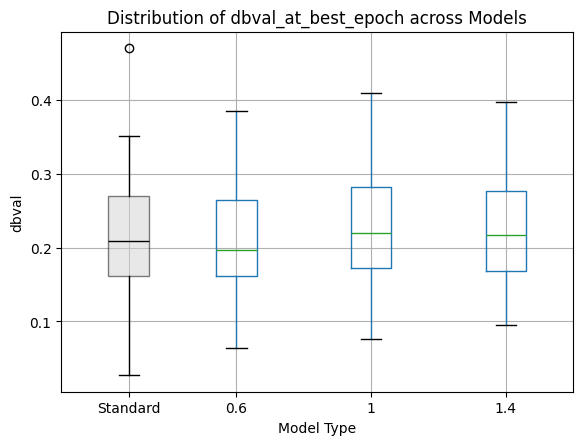

In [96]:
#Boxplot of dbval_at_best by model type.
box_plot(dbvae_final.record, standard_final.record, 'dbval')

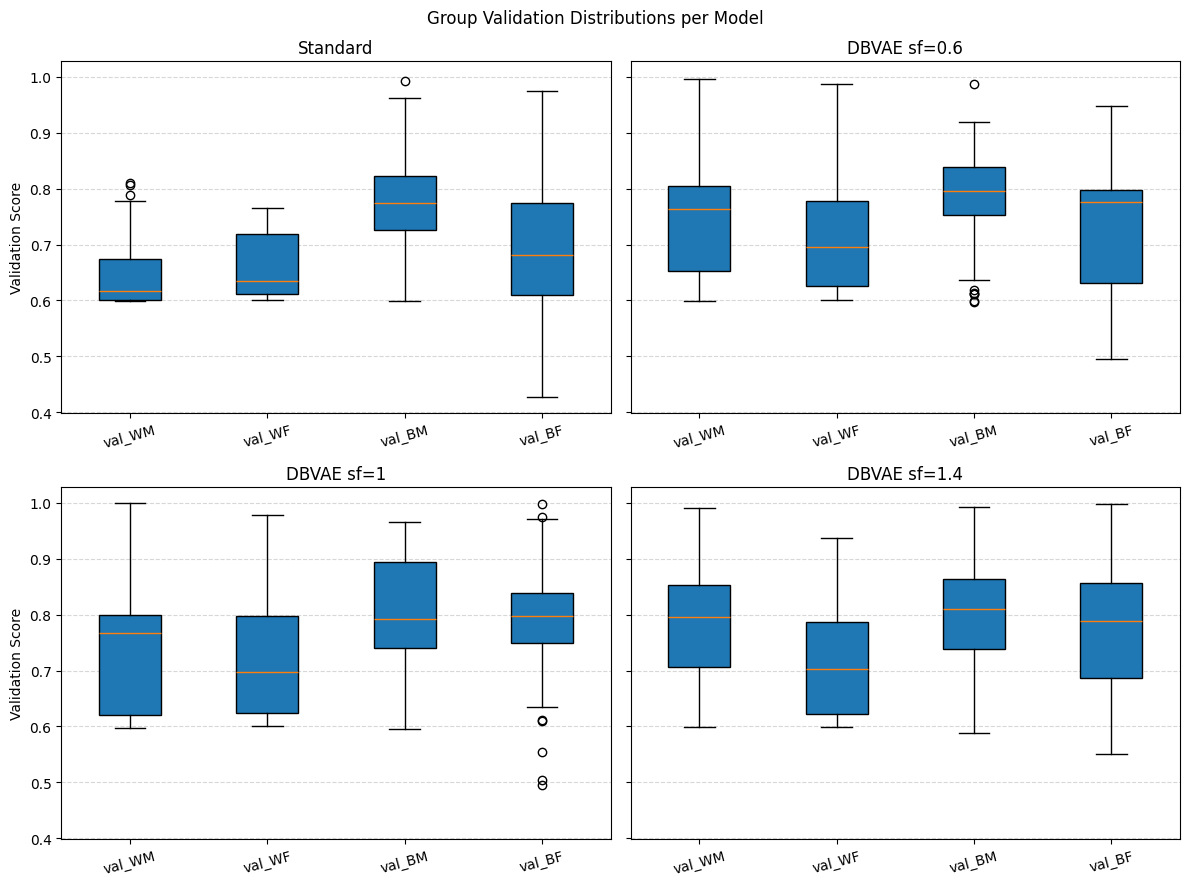

In [21]:
group_cols = ["val_WM", "val_WF", "val_BM", "val_BF"]
sfs = ["0.6", "1", "1.4"]

models = [
    ("Standard", standard_final.record),
    ("DBVAE sf=0.6", dbvae_final.record.loc[dbvae_final.record.smoothing_fact == "0.6"]),
    ("DBVAE sf=1",   dbvae_final.record.loc[dbvae_final.record.smoothing_fact == "1"]),
    ("DBVAE sf=1.4", dbvae_final.record.loc[dbvae_final.record.smoothing_fact == "1.4"]),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True)
axes = axes.ravel()

for ax, (title, df) in zip(axes, models):
    data = [df[c].astype(float).dropna().values for c in group_cols]

    ax.boxplot(
        data,
        tick_labels=group_cols,
        patch_artist=True
    )
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.tick_params(axis="x", rotation=15)

axes[0].set_ylabel("Validation Score")
axes[2].set_ylabel("Validation Score")

fig.suptitle("Group Validation Distributions per Model", y=0.98)
fig.tight_layout()
plt.show()


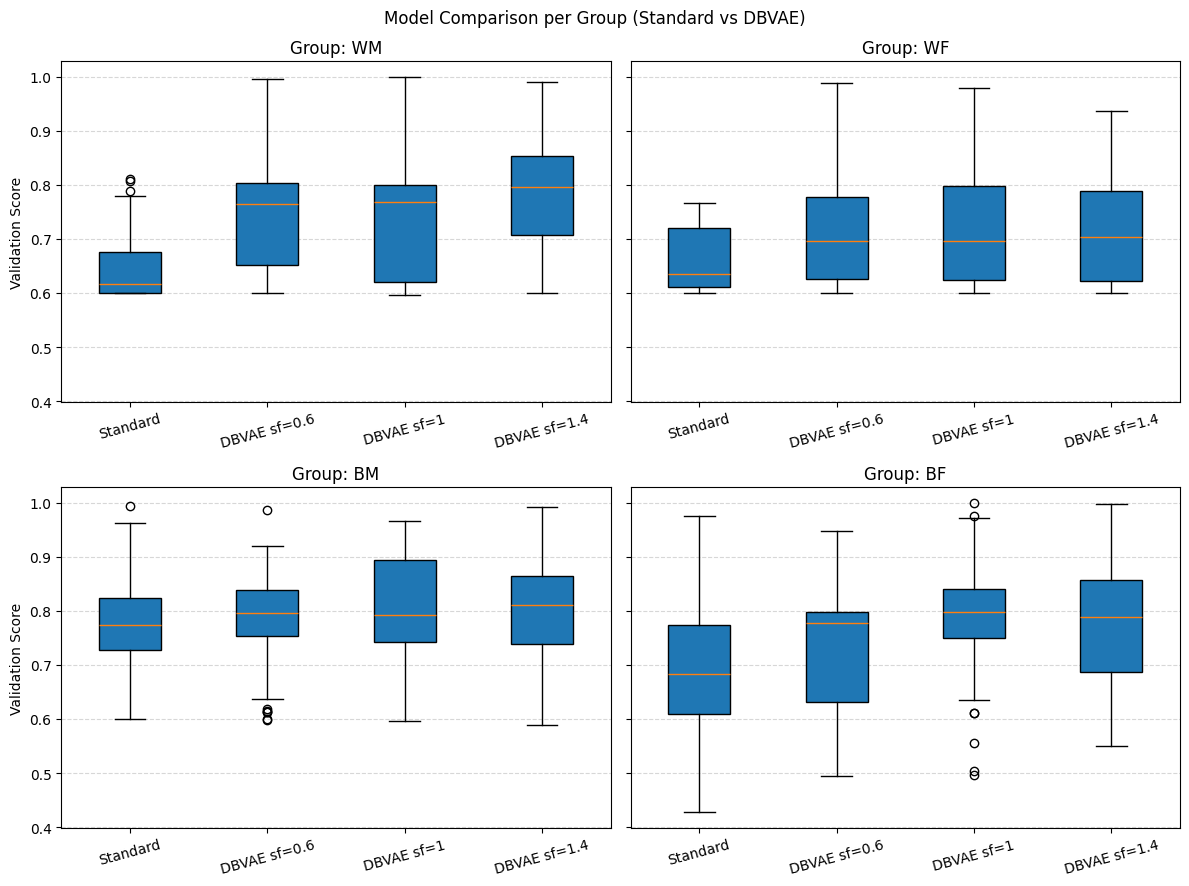

In [22]:
#comparing different model with same racial group

groups = ["WM", "WF", "BM", "BF"]
sfs = ["0.6", "1", "1.4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True)
axes = axes.ravel()

for ax, g in zip(axes, groups):
    col = f"val_{g}"

    data = []
    labels = []

    # 1) Standard model
    s_std = standard_final.record[col].astype(float).dropna()
    data.append(s_std.values)
    labels.append("Standard")

    # 2) DBVAE with different smoothing factors
    for sf in sfs:
        s_db = (
            dbvae_final.record
            .loc[dbvae_final.record.smoothing_fact == sf, col]
            .astype(float)
            .dropna()
        )
        data.append(s_db.values)
        labels.append(f"DBVAE sf={sf}")

    ax.boxplot(
        data,
        tick_labels=labels,
        patch_artist=True
    )

    ax.set_title(f"Group: {g}")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.tick_params(axis="x", rotation=15)

axes[0].set_ylabel("Validation Score")
axes[2].set_ylabel("Validation Score")

fig.suptitle("Model Comparison per Group (Standard vs DBVAE)", y=0.98)
fig.tight_layout()
plt.show()

standard cnn with 10 reps...
Processing dbvae smoothing=0.6 with 10 reps...
Processing dbvae smoothing=1 with 10 reps...
Processing dbvae smoothing=1.4 with 10 reps...
standard cnn with 10 reps...
Processing dbvae smoothing=0.6 with 10 reps...
Processing dbvae smoothing=1 with 10 reps...
Processing dbvae smoothing=1.4 with 10 reps...
standard cnn with 10 reps...
Processing dbvae smoothing=0.6 with 10 reps...
Processing dbvae smoothing=1 with 10 reps...
Processing dbvae smoothing=1.4 with 10 reps...
standard cnn with 10 reps...
Processing dbvae smoothing=0.6 with 10 reps...
Processing dbvae smoothing=1 with 10 reps...
Processing dbvae smoothing=1.4 with 10 reps...


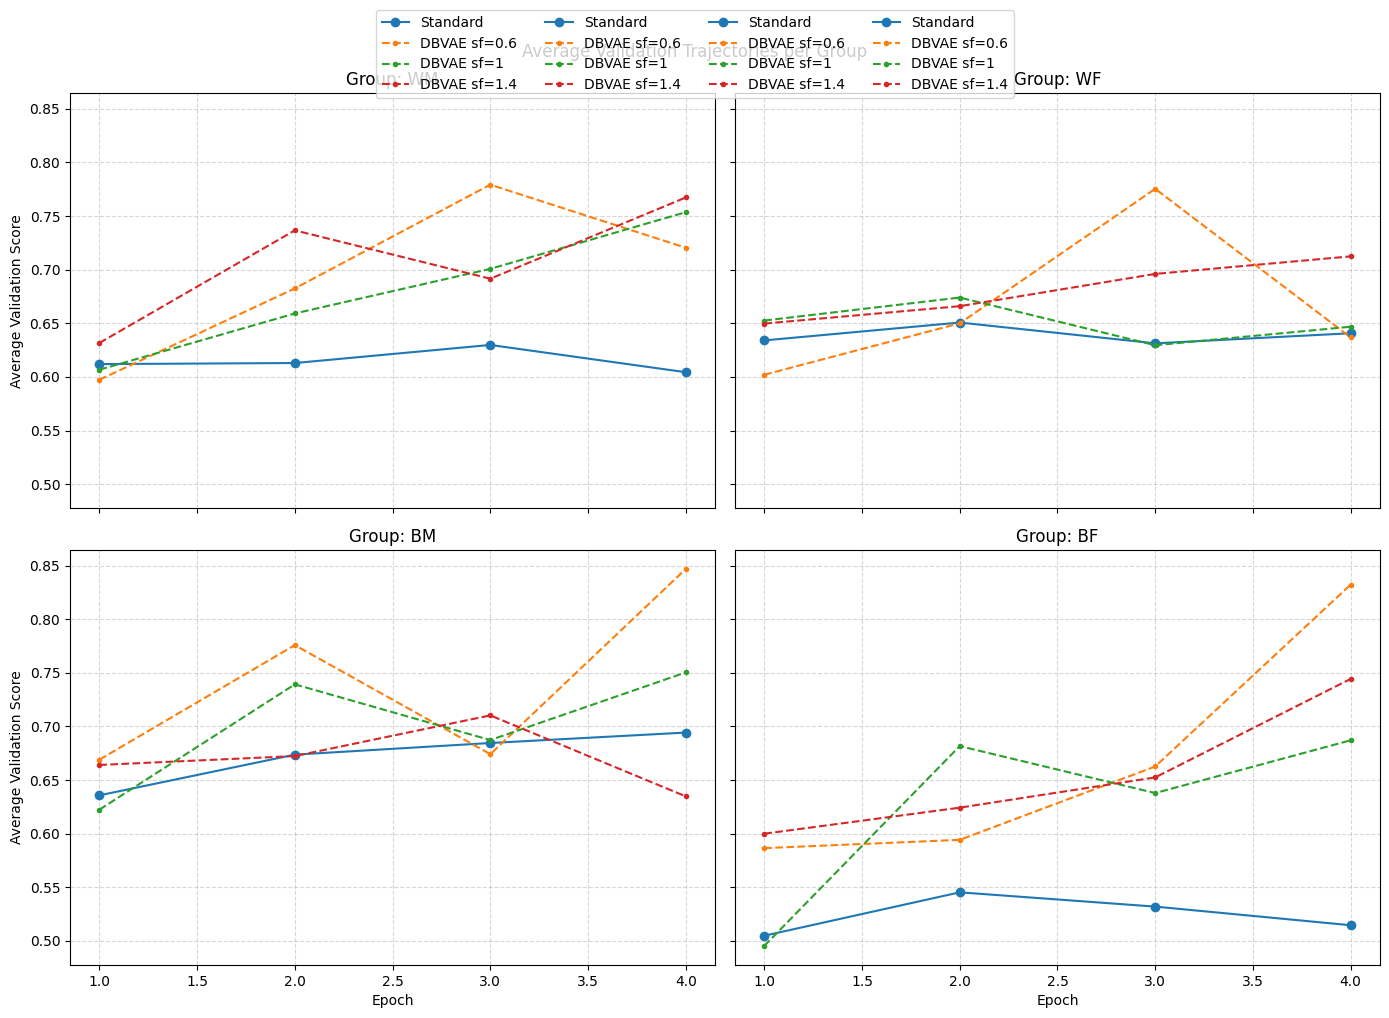

In [23]:
groups = ["WM", "WF", "BM", "BF"]
sfs = ["0.6", "1", "1.4"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, g in zip(axes, groups):
    metric = f"val_{g}"

    # --- compute trajectories ---
    std_traj_dict = get_epoch_avg_history(standard_final, metric)
    dbvae_traj_dict = get_epoch_avg_history(dbvae_final, metric)

    # --- Standard model ---
    std_traj = std_traj_dict.get("all", pd.Series(dtype=float))
    if not std_traj.empty:
        ax.plot(
            std_traj.index + 1,
            std_traj.values,
            label="Standard",
            linestyle="-",
            marker="o"
        )

    # --- DBVAE curves (by smoothing factor) ---
    for sf in sfs:
        traj = dbvae_traj_dict.get(sf)
        if traj is None or traj.empty:
            continue

        ax.plot(
            traj.index + 1,
            traj.values,
            label=f"DBVAE sf={sf}",
            linestyle="--",
            marker="."
        )

    ax.set_title(f"Group: {g}")
    ax.grid(True, linestyle="--", alpha=0.5)

# shared labels
axes[0].set_ylabel("Average Validation Score")
axes[2].set_ylabel("Average Validation Score")
axes[2].set_xlabel("Epoch")
axes[3].set_xlabel("Epoch")

fig.suptitle("Average Validation Trajectories per Group", y=0.98)
fig.tight_layout()
fig.legend(
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.02)
)

plt.show()


In [24]:
dbvae_val =  get_epoch_avg_history(dbvae, 'val')
dbvae_dbval = get_epoch_avg_history(dbvae, 'dbval')

Processing dbvae smoothing=0.6 with 93 reps...
Processing dbvae smoothing=1 with 100 reps...
Processing dbvae smoothing=1.4 with 100 reps...
Processing dbvae smoothing=0.6 with 93 reps...
Processing dbvae smoothing=1 with 100 reps...
Processing dbvae smoothing=1.4 with 100 reps...


In [25]:
Vae = []
Dbvae = []

# Collect all trajectories and find the maximum length
all_vae_trajectories = [list(sm) for sm in dbvae_val.values()]
all_dbvae_trajectories = [list(sm) for sm in dbvae_dbval.values()]

max_len_vae = 0
if all_vae_trajectories:
    max_len_vae = max(len(t) for t in all_vae_trajectories)

max_len_dbvae = 0
if all_dbvae_trajectories:
    max_len_dbvae = max(len(t) for t in all_dbvae_trajectories)

# Pad shorter trajectories with NaN to match the maximum length
for traj in all_vae_trajectories:
    Vae.append(traj + [np.nan] * (max_len_vae - len(traj)))

for traj in all_dbvae_trajectories:
    Dbvae.append(traj + [np.nan] * (max_len_dbvae - len(traj)))

Vae = np.array(Vae)
Dbvae = np.array(Dbvae)
comb = Vae-2*Dbvae

In [26]:
std_val = get_epoch_avg_history(standard, 'val')
std_dbval = get_epoch_avg_history(standard, 'dbval')


standard cnn with 102 reps...
standard cnn with 102 reps...


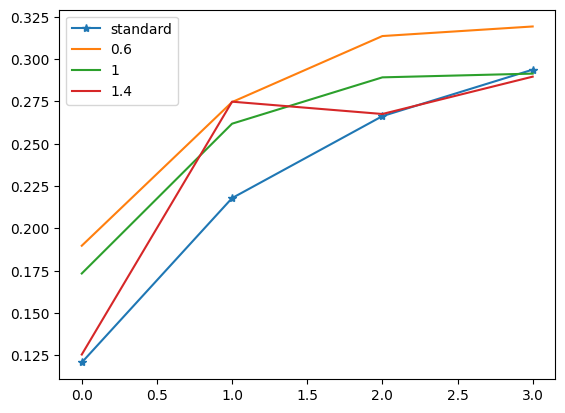

In [27]:
std_comb = std_val['all']-2*std_dbval['all']
plt.plot(std_comb, label = 'standard', marker = '*')
plt.plot(comb[0,:], label = '0.6')
plt.plot(comb[1,:],label = '1')
plt.plot(comb[2,:], label = '1.4')
plt.legend()
plt.show()